# Capstone Project: Battle of Neighborhoods

# Data Preparation

## List of Neighbourbohhds of Toronto

In [22]:
import pandas as pd
import wikipedia as wp

In [23]:
# import toronto neighbourhoods data from wikipedia page
# weblink: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]
df.columns = ['PostalCode', 'Borough','Neighbourhood']
df.drop([0],inplace=True)
df.head()

,PostalCode,Borough,Neighbourhood
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park


**Data PreProcessing for Neighbourhoods**
- remove neighbourhoods assigned no borough
- group neighbourhoods having same postal code
- deal with boroughs missing neighbourhoods

In [25]:
df = df[df.Borough != 'Not assigned']
d  = {'Borough':'first', 'Neighbourhood': lambda x: ', '.join(x)}
NH = df.groupby('PostalCode', as_index=False).aggregate(d).reindex(columns=df.columns)
mask = NH.Neighbourhood == 'Not assigned'
NH.loc[mask,'Neighbourhood']=NH.loc[mask,'Borough']
NH.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


##  Get Latitude and Longitude of each neighborhood

In [27]:
# import Lat-Long data from link given on course page
latlong = pd.read_csv('https://cocl.us/Geospatial_data')
latlong.rename(columns={"Postal Code": "PostalCode"},inplace=True)
latlong.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now join the two dataframes using the PostalCode column as a pivot

In [28]:
NH = pd.merge(NH, latlong, on='PostalCode', how='outer')
NH_loc_col = NH.columns
NH.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [2]:
#NH.to_csv('TO_NH.csv', sep=',',index=False)
#NH = pd.read_csv('TO_NH.csv')

## Demographics of Toronto Neighbourhoods

In [53]:
# import toronto neighbours demographics data from wikipedia
# weblink: https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods
html = wp.page("Demographics of Toronto neighbourhoods").html().encode("UTF-8")
df2 = pd.read_html(html)[1]
df2.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


**Data PreProcessing for Neighbourhoods Demographics**
- match neighbourhoods with previous data
- drops rows whose match was not found
- fill missing values

In [54]:
df2['Neighbourhood']='NaN'
for i,row in enumerate(df2['Name']):
    new_val = NH[NH['Neighbourhood'].str.contains(row)]['Neighbourhood'].values
    if len(new_val)!=0:
        df2['Neighbourhood'][i]=new_val[0]

df2 = df2[df2['Neighbourhood']!='NaN'][['Neighbourhood','Population','Land area (km2)','Density (people/km2)','Average Income']]
df2['Average Income']=df2['Average Income'].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
demo1 = df2[['Neighbourhood','Population','Land area (km2)']].groupby(['Neighbourhood']).sum()
demo2 = df2[['Neighbourhood','Density (people/km2)','Average Income']].groupby(['Neighbourhood']).mean()
NH_demo  = pd.merge(demo1, demo2, on='Neighbourhood', how='outer')
NH_demo  = pd.merge(NH_demo, NH['Neighbourhood'], on='Neighbourhood', how='outer')
NH_demo.fillna(NH_demo.mean(),inplace=True)
NH_demo[['Population','Density (people/km2)','Average Income']] = NH_demo[['Population','Density (people/km2)','Average Income']].astype(int)
NH_demo_col = NH_demo.columns
NH_demo.head()

,Neighbourhood,Population,Land area (km2),Density (people/km2),Average Income
0,Agincourt,44577,12.45,3580,25750
1,"Agincourt North, L'Amoreaux East, Milliken, St...",96830,18.86,5177,26092
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",16790,3.97,4229,28955
3,"Alderwood, Long Branch",21281,7.16,3348,36263
4,"Bathurst Manor, Downsview North, Wilson Heights",65290,24.96,2924,32966


In [246]:
#NH_demo.to_csv('TO_NH_demographics.csv', sep=',',index=False)

## Exploring Neighborhoods and preparing Venues Data

In [30]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [31]:
# Use geopy library to get the latitude and longitude values of Toronto.
address = 'Toronto, ON'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto with neighborhoods superimposed on top.

In [32]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(NH['Latitude'], NH['Longitude'], NH['Borough'], NH['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Get Nearby Venues

In [33]:
# define the foursquare url paramters.
CLIENT_ID = '2MBNGQFZVL21GANE0HGY324SISAVELOMUCUMEO3AZ3BZNNBR' # your Foursquare ID
CLIENT_SECRET = 'EQ2RYI3Z4N5A4XFCH1DFAIJRY4PUZL3KK3S5IZU5I3W15C0E' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=120
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2MBNGQFZVL21GANE0HGY324SISAVELOMUCUMEO3AZ3BZNNBR
CLIENT_SECRET:EQ2RYI3Z4N5A4XFCH1DFAIJRY4PUZL3KK3S5IZU5I3W15C0E


In [35]:
def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500):  
    venues_list=[]
    for post,name, lat, lng in zip(postalcodes, names, latitudes, longitudes):   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            post,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighbourhood',   
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
TO_venues = getNearbyVenues(postalcodes=NH['PostalCode'],
                               names=NH['Neighbourhood'],
                                 latitudes=NH['Latitude'], 
                                 longitudes=NH['Longitude'])

In [38]:
print(TO_venues.shape)
TO_venues.head()

(2232, 8)


,PostalCode,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [243]:
#TO_venues.to_csv('TO_venues.csv', sep=',',index=False)

### Analyze Each Neighborhood

In [39]:
NH_venues = TO_venues[['Neighbourhood','PostalCode']].groupby('Neighbourhood').count()
NH_venues.reset_index(inplace=True)
NH_venues.rename(columns = {'PostalCode':'Venue Count'}, inplace = True)

In [40]:
# one hot encoding
TO_venues_onehot = pd.get_dummies(TO_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
TO_venues_onehot['Neighbourhood'] = TO_venues['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [TO_venues_onehot.columns[-1]] + list(TO_venues_onehot.columns[:-1])
TO_venues_onehot = TO_venues_onehot[fixed_columns]
NH_venues_grouped = TO_venues_onehot.groupby('Neighbourhood').sum().reset_index()

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
NH_venues_sorted = pd.DataFrame(columns=columns)
NH_venues_sorted['Neighbourhood'] = NH_venues_grouped['Neighbourhood']

for ind in np.arange(NH_venues_grouped.shape[0]):
    NH_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NH_venues_grouped.iloc[ind, :], num_top_venues)

In [45]:
NH_venues = pd.merge(NH_venues, NH_venues_sorted, on='Neighbourhood', how='outer')
NH_venues = pd.merge(NH_venues, NH_venues_grouped, on='Neighbourhood', how='outer')
top3 = NH_venues[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']].apply(lambda x: ', '.join(x), axis=1)
NH_venues.insert(loc=2, column='Top 3 Venues', value = top3)
NH_venues.head()

,Neighbourhood,Venue Count,Top 3 Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game St

In [244]:
#NH_venues.to_csv('TO_NH_venues.csv', sep=',',index=False)

# Clustering Neighborhoods

## Clustering with-respect-to Venues

### Estimate Optimal Number of Clusters

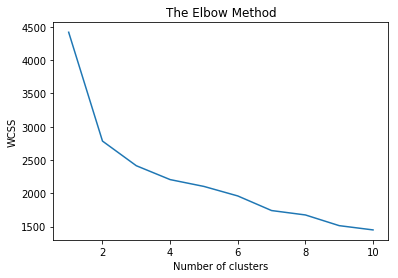

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
X = NH_venues[NH_venues_grouped.columns[1:]]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It can be seen that correct number of custers should be 2 or 3. I will go with 3 clusters.

### Run k-means to find Clusters

In [47]:
# run k-means clustering
kclusters = 3
X = NH_venues[NH_venues_grouped.columns[1:]]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

In [48]:
# add cluster labels to neighbourhoods
clustering_data = NH_venues.iloc[:,0:3]
clustering_data.insert(loc=1, column='Cluster Label', value=kmeans.labels_)

In [49]:
cluster_labels = clustering_data[['Cluster Label','Venue Count']].groupby(['Cluster Label']).count().reset_index()
cluster_labels['Venue Count Mean'] = clustering_data[['Cluster Label','Venue Count']].groupby(['Cluster Label']).mean()
description = ['Mid Venue Count','High Venue Count','Low Venue Count']
cluster_labels['Description'] = description
cluster_labels.rename(index=str, columns={"Venue Count": "Neighbourhood Count"},inplace=True)
cluster_labels

,Cluster Label,Neighbourhood Count,Venue Count Mean,Description
0,0,14,50.571429,Mid Venue Count
1,1,9,97.555556,High Venue Count
2,2,77,8.389610,Low Venue Count


### Now visualize the clusters

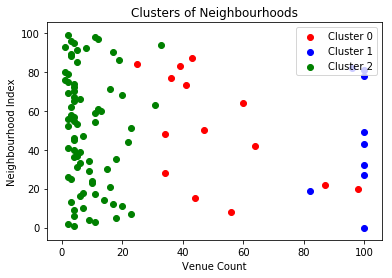

In [131]:
color = ['red','blue','green']
plt.figure()
for i in range(0,3):
    mask = clustering_data['Cluster Label']==i
    plt.scatter(clustering_data[mask]['Venue Count'], clustering_data[mask].index, c = color[i], label = 'Cluster '+ str(i))
plt.title('Clusters of Neighbourhoods')
plt.xlabel('Venue Count')
plt.ylabel('Neighbourhood Index')
plt.legend(loc='upper right')
plt.show()

In [50]:
#clustering_data.replace([0, 1, 2], ['Mid Venue Count','Low Venue Count','High Venue Count'],inplace=True)
NH_clustered = pd.merge(clustering_data, NH[['Neighbourhood','Latitude','Longitude']], on='Neighbourhood', how='inner')
NH_clustered

,Neighbourhood,Cluster Label,Venue Count,Top 3 Venues,Latitude,Longitude
0,"Adelaide, King, Richmond",1,100,"Coffee Shop, Café, Bar",43.650571,-79.384568
1,Agincourt,2,4,"Sandwich Place, Lounge, Breakfast Spot",43.794200,-79.262029
2,"Agincourt North, L'Amoreaux East, Milliken, St...",2,2,"Playground, Park, Drugstore",43.815252,-79.284577
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",2,11,"Grocery Store, Pharmacy, Coffee Shop",43.739416,-79.588437
4,"Alderwood, Long Branch",2,9,"Pizza Place, Pharmacy, Gym",43.602414,-79.543484
5,"Bathurst Manor, Downsview North, Wilson Heights",2,18,"Coffee Shop, Pharmacy, Deli / Bodega",43.754328,-79.442259
6,Bayview Village,2,4,"Café, Japanese Restaurant, Bank",43.786947,-79.385975
7,"Bedford Park, Lawrence Manor East",2,23,"Italian Restaurant, Fast Food Restaurant, Coff...",43.733283,-79.419750
8,Berczy Park,0,56,"Coffee Shop, Cocktail Bar, Italian Restaurant",43.644771,-79.373306
9,"Birch Cliff, Cliffside West",2,4,"Café, General Entertainment, Skating Rink",43.692657,-79.264848


In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red','blue','green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NH_clustered['Latitude'], NH_clustered['Longitude'], NH_clustered['Neighbourhood'], NH_clustered['Cluster Label']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster)+ ': '+ str(cluster_labels['Description'][cluster]), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Results**
- As expected high venue count neighbourhoods are clustered in the city center. 
- The low venue count neighbourhoods are in suburbs.

## Clustering w.r.t Demographics

In [60]:
NH_demo_clustering  = pd.merge(NH_demo, NH[['Neighbourhood','Latitude','Longitude']], on='Neighbourhood', how='inner')
NH_demo_clustering.head()

,Neighbourhood,Population,Land area (km2),Density (people/km2),Average Income,Latitude,Longitude
0,Agincourt,44577,12.45,3580,25750,43.794200,-79.262029
1,"Agincourt North, L'Amoreaux East, Milliken, St...",96830,18.86,5177,26092,43.815252,-79.284577
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",16790,3.97,4229,28955,43.739416,-79.588437
3,"Alderwood, Long Branch",21281,7.16,3348,36263,43.602414,-79.543484
4,"Bathurst Manor, Downsview North, Wilson Heights",65290,24.96,2924,32966,43.754328,-79.442259


### Estimate Optimal Number of Clusters

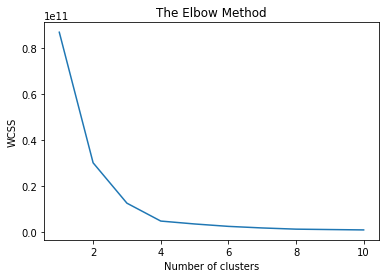

In [115]:
X2 = NH_demo_clustering[['Density (people/km2)','Average Income']]
wcss2 = []
for i in range(1, 11):
    kmeans2 = KMeans(n_clusters = i, random_state = 42)
    kmeans2.fit(X2)
    wcss2.append(kmeans2.inertia_)
plt.plot(range(1, 11), wcss2)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Run k-means to find Clusters

In [57]:
# run k-means clustering
kclusters2 = 5
X2 = NH_demo_clustering[['Density (people/km2)','Average Income']]
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(X2)

In [61]:
# add cluster labels to neighbourhoods
NH_demo_clustering.insert(loc=1, column='Cluster Label', value=kmeans2.labels_)
#NH_demo_clustering
NH_demo_clustering.iloc[0:5,0:6]

,Neighbourhood,Cluster Label,Population,Land area (km2),Density (people/km2),Average Income
0,Agincourt,3,44577,12.45,3580,25750
1,"Agincourt North, L'Amoreaux East, Milliken, St...",3,96830,18.86,5177,26092
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",3,16790,3.97,4229,28955
3,"Alderwood, Long Branch",3,21281,7.16,3348,36263
4,"Bathurst Manor, Downsview North, Wilson Heights",3,65290,24.96,2924,32966


### Now visualize the clusters

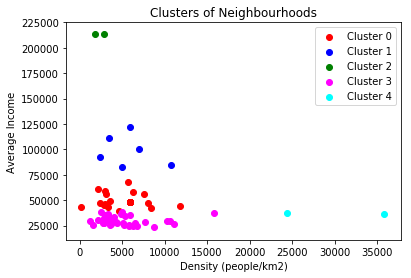

In [62]:
color = ['red','blue','green','magenta','cyan']
plt.figure()
for i in range(0,5):
    mask = NH_demo_clustering['Cluster Label']==i
    plt.scatter(NH_demo_clustering[mask]['Density (people/km2)'], NH_demo_clustering[mask]['Average Income'], c = color[i], label = 'Cluster '+ str(i))
plt.title('Clusters of Neighbourhoods')
plt.xlabel('Density (people/km2)')
plt.ylabel('Average Income')
plt.legend()
plt.show()

In [63]:
cluster_labels2 = NH_demo_clustering[['Cluster Label','Density (people/km2)','Average Income']].groupby(['Cluster Label']).mean().reset_index()
description2 = ['Mid Dense Mid Income','Mid Dense High Income','Low Dense Very High Income','Mid Dense Low Income','High Dense Low Income']
cluster_labels2['Description'] = description2
#cluster_labels.rename(index=str, columns={"Venue Count": "Neighbourhood Count"},inplace=True)
cluster_labels2

,Cluster Label,Density (people/km2),Average Income,Description
0,0,5566.310345,48996.275862,Mid Dense Mid Income
1,1,5717.666667,98826.666667,Mid Dense High Income
2,2,2324.500000,214025.500000,Low Dense Very High Income
3,3,5234.571429,30101.542857,Mid Dense Low Income
4,4,30106.000000,37011.000000,High Dense Low Income


In [64]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters2)
ys = [i+x+(i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red','blue','green','magenta','cyan']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NH_demo_clustering['Latitude'], NH_demo_clustering['Longitude'], NH_demo_clustering['Neighbourhood'], NH_demo_clustering['Cluster Label']):
    #label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster)+ ': '+ str(cluster_labels2['Description'][cluster]), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters